#### Попробуем мою реализацию ЯМРК4(5)

In [256]:
# -*- coding: utf-8 -*-
# from gist: https://gist.github.com/aubricus/f91fb55dc6ba5557fbab06119420dd6a
from __future__ import division
import sys

# Для печати прогресса
def print_progress(iteration, total, prefix='', suffix='', decimals=1, bar_length=100):
    """
    Call in a loop to create terminal progress bar

    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        bar_length  - Optional  : character length of bar (Int)
    """
    str_format = "{0:." + str(decimals) + "f}"
    percents = str_format.format(100 * (iteration / float(total)))
    filled_length = int(round(bar_length * iteration / float(total)))
    bar = '█' * filled_length + '-' * (bar_length - filled_length)

    sys.stdout.write('\r%s |%s| %s%s %s' % (prefix, bar, percents, '%', suffix)),

    if iteration == total:
        sys.stdout.write('\n')
    sys.stdout.flush()

In [252]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
import numpy as np
import math

#здесь задаем функцию
def F(x,z, p):
    f = np.zeros(3)
    f[0] = -np.sin(p)
    f[1] = -100 * np.sin(100*z)
    f[2] = x
    return f

In [219]:
#ЯМРК4(5)
def ERKM4(x,z,epsilon,h,N):
    #для решений
    Y4 = np.zeros((3))
    Y4 = [x,z,epsilon]
    Y5 = np.zeros((3))
    Y5 = [x,z,epsilon]
    #сюда записываем отыеты для каждой переменной
    val1 = [x]
    val2 = [z]
    val3 = [epsilon]
    #точки по времени
    arg = [0]
    #записываем значение длины шага
    featureh = []
    #принят, не принят
    validwin = []
    abstol = reltol = 1.0e-3
    #фактор сохранности
    fac = 0.8
    #границы интегрирования
    t = 0
    tf = math.pi
    #счетчики
    acc = 0
    rej = 0;
    #
    while tf - t > 0:
        print_progress(int(t/tf*100), 100)
        k1 = F(x,z, epsilon)
        k2 = F(x + k1[0]/4,z + k1[1]/4, epsilon + k1[2]/4);
        k3 = F(x + k1[0]*3/32 + k2[0]*9/32,z + k2[1]*3/32 + k2[1]*9/32, epsilon+ k2[2]*3/32 + k2[2]*9/32);
        k4 = F(x + k1[0]*1932/2197 - k2[0]*7200/2197 + k3[0]*7296/2197,z + k1[1]*1932/2197 -
                 k2[1]*7200/2197 + k3[1]*7296/2197, epsilon + k1[2]*1932/2197 - k2[2]*7200/2197 + k3[2]*7296/2197);
        k5 = F(x + k1[0]* 439/216 - k2[0]*8 + k3[0]*3680/513 - k4[0] *845/4104,z + k1[1]* 439/216 - 
                 k2[1]*8 + k3[1]*3680/513 - k4[1] *845/4104, epsilon + k1[2]* 439/216 - 
                 k2[2]*8 + k3[2]*3680/513 - k4[2] *845/4104);
        k6 = F(x - k1[0]* 8/27 + k2[0]*2 - k3[0]*3544/2565 + k4[0] *1859/4104 - k5[0]*11/40,z - 
                 k1[1]* 8/27 + k2[1]*2 - k3[1]*3544/2565 + k4[1] *1859/4104 - k5[1]*11/40, epsilon - 
                 k1[2]* 8/27 + k2[2]*2 - k3[2]*3544/2565 + k4[2] *1859/4104 - k5[2]*11/40);
        Ypred = Y4
        #считаем ЯМРК4 и ЯМРК5, чтобы посчитать ошибку между двумя решениями разной точности
        Y4 = Y4 + h*(25/216*k1 + 1408/2565*k3 + 2197/4104*k4 - 1/5*k5)
        Y5 = Y5 + h*(16/135*k1  + 6656/12825*k3 + 28561/56430*k4 - 9/50*k5 + 2/55*k6)
        #считаем ошибку
        #err = np.linalg.norm(Y5 - Y4)
        yerr = h*(16/135*k1  + 6656/12825*k3 + 28561/56430*k4 - 9/50*k5 + 2/55*k6 - 
                  (25/216*k1 + 1408/2565*k3 + 2197/4104*k4 - 1/5*k5))
        #нормируем ошибку, чтобы удобно было сравнивать
        sc   = abstol + np.maximum(np.abs(Ypred), np.abs(Y4)) * reltol
        err  = max(np.sqrt(np.sum((yerr / sc)**2)/n), 1.0e-10)
        #print(err)
        if err <= 1: #тогда шаг нормальный
            #записываем решение
            x = Y4[0]
            val1.append(x)
            z = Y4[1]
            val2.append(z)
            epsilon = Y4[2]
            val3.append(epsilon)
            arg.append(arg[-1] + h)
            #двигаем время
            t = t + h
            #заполняем датасет
            featureh.append(h)
            validwin.append(1)
            #считаем новое значение h
            h = h * min(1.0, max(0.2, fac * (1/err)**(1/5)))
            acc += 1
        else:
            #заполняем датасет
            featureh.append(h)
            validwin.append(0)
            #считаем новое значение h
            h = h * min(1.0, max(0.2, fac * (1/err)**(1/5)))
            rej += 1;
    return arg, val1, val2, val3, featureh, validwin, acc, rej

In [255]:
import time
start_time = time.time()
x = 1
z = 1
n = 3
epsilon = 0
N = 1000
arg, val1, val2, val3, featureh, validwin, acc, rej = ERKM4(x,z,epsilon,1.0e-2,N)
print('')
print('Accepted steps: ',acc)
print('Rejected steps', rej)
print("Time: %s seconds" % (time.time() - start_time))

 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 
Accepted steps:  45406
Rejected steps 7
Time: 44.301340103149414 seconds


In [226]:
from sklearn.linear_model import LinearRegression
featureh = np.array(featureh)
#обучаем модель
reg = LinearRegression().fit(featureh.reshape(-1,1), validwin)
from sklearn.externals import joblib
#сохраняем ее
joblib.dump(reg, 'easy_eq_my.joblib')

['easy_eq_my.joblib']

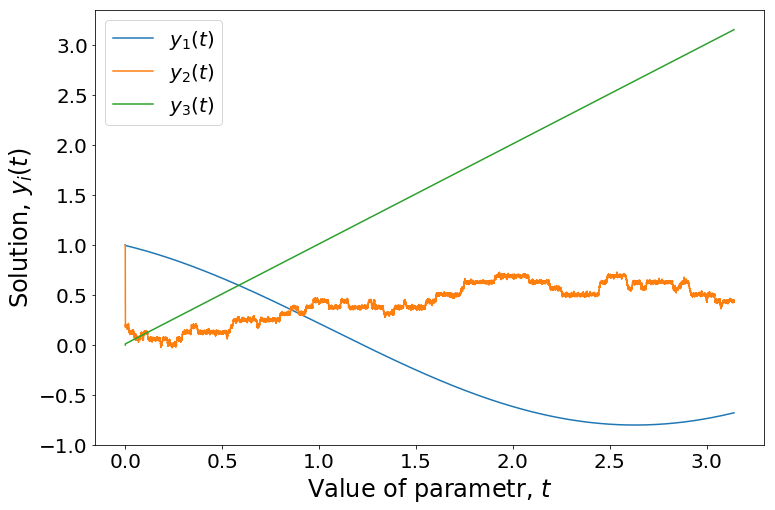

In [238]:
#Строим графики решения системы
plt.figure(figsize=(12,8))
plt.plot(arg,val1, label=r"$y_1(t)$")
plt.plot(arg,val2, label=r"$y_2(t)$")
plt.plot(arg,val3, label=r"$y_3(t)$")
plt.xlabel("Value of parametr, $t$", fontsize=24)
plt.ylabel("Solution, $y_i(t)$", fontsize=24)
plt.legend(loc="best", fontsize=20)
plt.xticks(fontsize = 20)
_ = plt.yticks(fontsize = 20)
plt.savefig('my_auto.png')
plt.show()

In [1]:
#ЯМРК4ML:
#Все то же самое, только теперь уменьшаем будущий шаг, если модель говорит, что он будет отвергнут
def ERKM4ML(x,z,epsilon,h,N,model):
    Y4 = np.zeros((3))
    Y4 = [x,z,epsilon]
    Y5 = np.zeros((3))
    Y5 = [x,z,epsilon]
    val1 = [x]
    val2 = [z]
    val3 = [epsilon]
    abstol = reltol = 1.0e-3
    #фактор сохранности
    fac = 0.8
    t = 0
    tf = math.pi
    acc = 0
    rej = 0;
    while tf - t > 0:
        print_progress(int(t/tf*100), 100)
        k1 = F(x,z, epsilon)
        k2 = F(x + k1[0]/4,z + k1[1]/4, epsilon + k1[2]/4);
        k3 = F(x + k1[0]*3/32 + k2[0]*9/32,z + k2[1]*3/32 + k2[1]*9/32, epsilon+ k2[2]*3/32 + k2[2]*9/32);
        k4 = F(x + k1[0]*1932/2197 - k2[0]*7200/2197 + k3[0]*7296/2197,z + k1[1]*1932/2197 -
                 k2[1]*7200/2197 + k3[1]*7296/2197, epsilon + k1[2]*1932/2197 - k2[2]*7200/2197 + k3[2]*7296/2197);
        k5 = F(x + k1[0]* 439/216 - k2[0]*8 + k3[0]*3680/513 - k4[0] *845/4104,z + k1[1]* 439/216 - 
                 k2[1]*8 + k3[1]*3680/513 - k4[1] *845/4104, epsilon + k1[2]* 439/216 - 
                 k2[2]*8 + k3[2]*3680/513 - k4[2] *845/4104);
        k6 = F(x - k1[0]* 8/27 + k2[0]*2 - k3[0]*3544/2565 + k4[0] *1859/4104 - k5[0]*11/40,z - 
                 k1[1]* 8/27 + k2[1]*2 - k3[1]*3544/2565 + k4[1] *1859/4104 - k5[1]*11/40, epsilon - 
                 k1[2]* 8/27 + k2[2]*2 - k3[2]*3544/2565 + k4[2] *1859/4104 - k5[2]*11/40);
        Ypred = Y4
        #считаем ЯМРК4 и ЯМРК5, чтобы посчитать ошибку между двумя решениями разной точности
        Y4 = Y4 + h*(25/216*k1 + 1408/2565*k3 + 2197/4104*k4 - 1/5*k5)
        Y5 = Y5 + h*(16/135*k1  + 6656/12825*k3 + 28561/56430*k4 - 9/50*k5 + 2/55*k6)
        #считаем ошибку
        yerr = h*(16/135*k1  + 6656/12825*k3 + 28561/56430*k4 - 9/50*k5 + 2/55*k6 - 
                  (25/216*k1 + 1408/2565*k3 + 2197/4104*k4 - 1/5*k5))
        #нормируем ошибку, чтобы удобно было сравнивать
        sc   = abstol + np.maximum(np.abs(Ypred), np.abs(Y4)) * reltol
        err  = max(np.sqrt(np.sum((yerr / sc)**2)/n), 1.0e-10)
        if err <= 1: #тогда шаг нормальный
            #записываем решение
            x = Y4[0]
            val1.append(x)
            z = Y4[1]
            val2.append(z)
            epsilon = Y4[2]
            val3.append(epsilon)
            arg.append(arg[-1] + h)
            t = t + h
            #считаем новое значение h
            h = h * min(1.0, max(0.2, fac * (1/err)**(1/5)))
            #будет ли принят следующий шаг?
            acceptnext = model.predict(np.array([[h]]))[0]
            #если нет, уменьшаем величину шага
            while acceptnext < 1:
                h = 0.9*h
                acceptnext = model.predict(np.array([[h]]))[0]
            acc += 1
        else:
            h = h * min(1.0, max(0.2, fac * (1/err)**(1/5)))
            #будет ли принят следующий шаг?
            acceptnext = model.predict(np.array([[h]]))[0]
            #если нет, уменьшаем величину шага
            while acceptnext < 1:
                h = 0.9*h
                acceptnext = model.predict(np.array([[h]]))[0]
            rej += 1;
    return arg, val1, val2, val3, featureh, validwin, acc, rej

In [232]:
#для теста модели из оригинальгого метода, где точно так же реализовано обучение
reg1 = joblib.load('easy_eq.joblib')

In [257]:
start_time = time.time()
x = 1
z = 1
n = 3
epsilon = 0
N = 1000
arg, val1, val2, val3, featureh, validwin, acc, rej = ERKM4ML(x,z,epsilon,1.0e-2,N,reg)
print('')
print('Accepted steps: ',acc)
print('Rejected steps', rej)
print("Time: %s seconds" % (time.time() - start_time))

 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 
Accepted steps:  56799
Rejected steps 1
Time: 63.2522554397583 seconds
